In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def check_season_data(league, season):
    season_dir = f'{league}_{season}'
    data = []
    for sheet in os.listdir(f'data/{season_dir}'):
        temp = pd.read_csv(f'data/{season_dir}/{sheet}').tail(3)
        data.append([sheet.strip('.csv'), temp['W-L'].values[0]])
    df = pd.DataFrame(data, columns=['Team', 'Record'])
    df['W'] = df['Record'].apply(lambda x: x.split('-')[0]).apply(int)
    df['L'] = df['Record'].apply(lambda x: x.split('-')[1]).apply(int)
    df['W%'] = df['W'] / (df['W'] + df['L'])
    return df.sort_values('W%', ascending=False).drop(['W', 'L'], axis=1)

In [5]:
def calculate_pace(team_df):
    temp = team_df.to_dict(orient='records')
    team_records = {'Team': temp[0],
                    'Opponent': temp[1]}
    total_poss = 0
    for side in ['Team', 'Opponent']:
        total_poss += team_records[side]['FGA'] - \
                      team_records[side]['Or'] + \
                      team_records[side]['To'] + \
                      0.44 * team_records[side]['FTA']

    return total_poss / 2, team_records['Team']['MIN'] / 5

In [29]:
def process_team_sheet(team_sheet, season_dir):
    # Initial Process
    df = pd.read_csv(f'data/{season_dir}/{team_sheet}')
    
    shooting_cols = ['2P', '3P', 'FG', 'FT']
    for col in shooting_cols:
        df[f'{col}M'] = df[col].apply(lambda x: x.split('/')[0])\
                               .apply(int)
        df[f'{col}A'] = df[col].apply(lambda x: x.split('/')[1])\
                               .apply(int)
    df.drop(shooting_cols + [col for col in df.columns
                             if '.1' in col], 
            inplace=True, axis=1)
    df['Dr'] = df['Reb'] - df['Or']
    
    # Calculate pace
    team_df = df.tail(3).copy()
    team_poss, team_min = calculate_pace(team_df)
    
    # Get Estimates of players' possessions
    df = df[~df['Height'].isna()]
    df['Poss_est'] = df['MIN'] / team_min * team_poss
    
    return df

In [46]:
def process_season_sheets(season, league):
    season_dir = f'{league}_{season}'
    dfs = [process_team_sheet(team_sheet, season_dir)
           for team_sheet in os.listdir(f'data/{season_dir}/')
           if '.csv' in team_sheet]
    df = pd.concat(dfs).reset_index(drop=True)
    df['Season'] = season
    return df

## Process Eurocup

In [47]:
league = 'Eurocup'

In [63]:
seasons = list(range(2018, 2022))

In [55]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2021
# check_season_data(league, 2021)

In [57]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2020
# check_season_data(league, 2020)

In [59]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2019
# check_season_data(league, 2019)

In [61]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2018
# check_season_data(league, 2018)

In [66]:
df = pd.concat([process_season_sheets(season, league)
                for season in seasons])\
       .reset_index(drop=True)
df.shape

(1390, 27)

<AxesSubplot: >

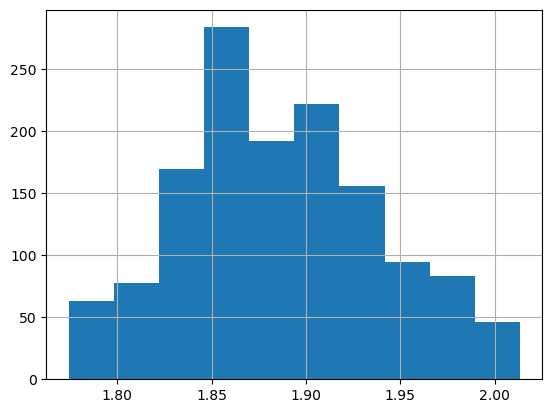

In [67]:
(df['Poss_est'] / df['MIN']).hist()

In [68]:
df.to_csv('proballers_eurocup_stats.csv', index=False)